# TUnfoldDensity example with pyroot

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

ROOT.gStyle.SetOptStat(000000)

Welcome to JupyROOT 6.20/04


## Generate the response matrix

Here, we have a respone matrix with 10 coarse and 20 fine bins (configurable). The variable of interest ($x$) ranges from 0 to 100. We assume the resolution on $x$ is 1.0, and that there is a systematic uncertainty "scale", which has an "up" and "down" variation of 2%. We generate 10000 pseudo-events for each value of x between 0 and 100, smeared by the resolution. For each of the "x" values, a reconstructed "y" value is constructed, again smeared by the resolution. We then add the "up" and "down" scale uncertainites. Finally, we construct TH2 matrices that represent the response matrices. 

In [2]:
coarsebins = 10
finebins = 20
minval = 0
maxval = 100
M = ROOT.TH2D("M", "M", coarsebins,minval,maxval, finebins,minval,maxval)
M1 = M.Clone("M1")
M2 = M.Clone("M2")
M1.SetTitle("+1#sigma")
M2.SetTitle("-1#sigma")

res = 1.0
scaleup = 1.02
scaledn = 0.98

Npe = 10000
v = np.linspace(minval, maxval, maxval+1)


# First get a Gaussian centered at each bin with the experimental resolution
rx = np.random.normal( loc=v, scale=res, size=(Npe,v.size) )
ry = np.random.normal( loc=rx, scale=res)

In [3]:
# Next scale the reco up and down
ry_up = ry*scaleup
ry_dn = ry*scaledn

for i in np.arange(len(rx)):    
    for j in np.arange(len(ry[i])):
        x = rx[i][j]
        y = ry[i][j]
        yu= ry_up[i][j]
        yd= ry_dn[i][j]
        #print ' %10.7f %10.7f + %10.7f - %10.7f ' % ( x, y, yu, yd )
        M.Fill(x, y, 1./Npe)
        M1.Fill(x, yu, 1./Npe)
        M2.Fill(x, yd, 1./Npe)
        

#for i in xrange(0,20):
#    M.SetBinContent(i,2*i, 0.8) 
#    M1.SetBinContent(i,2*i, (+i*0.010) )
#    M2.SetBinContent(i,2*i, (-i*0.010) )
#    M.SetBinContent(i,2*i-1, 0.2) 
#    M1.SetBinContent(i,2*i-1,(i*0.001) )
#    M2.SetBinContent(i,2*i-1, (-i*0.001) )

#M.SetBinContent(12,12,1.0)
#M1.SetBinContent(12,12, 12*0.01)

## Draw the response matrix

We draw the nominal and $\pm 1 \sigma$ variations. 

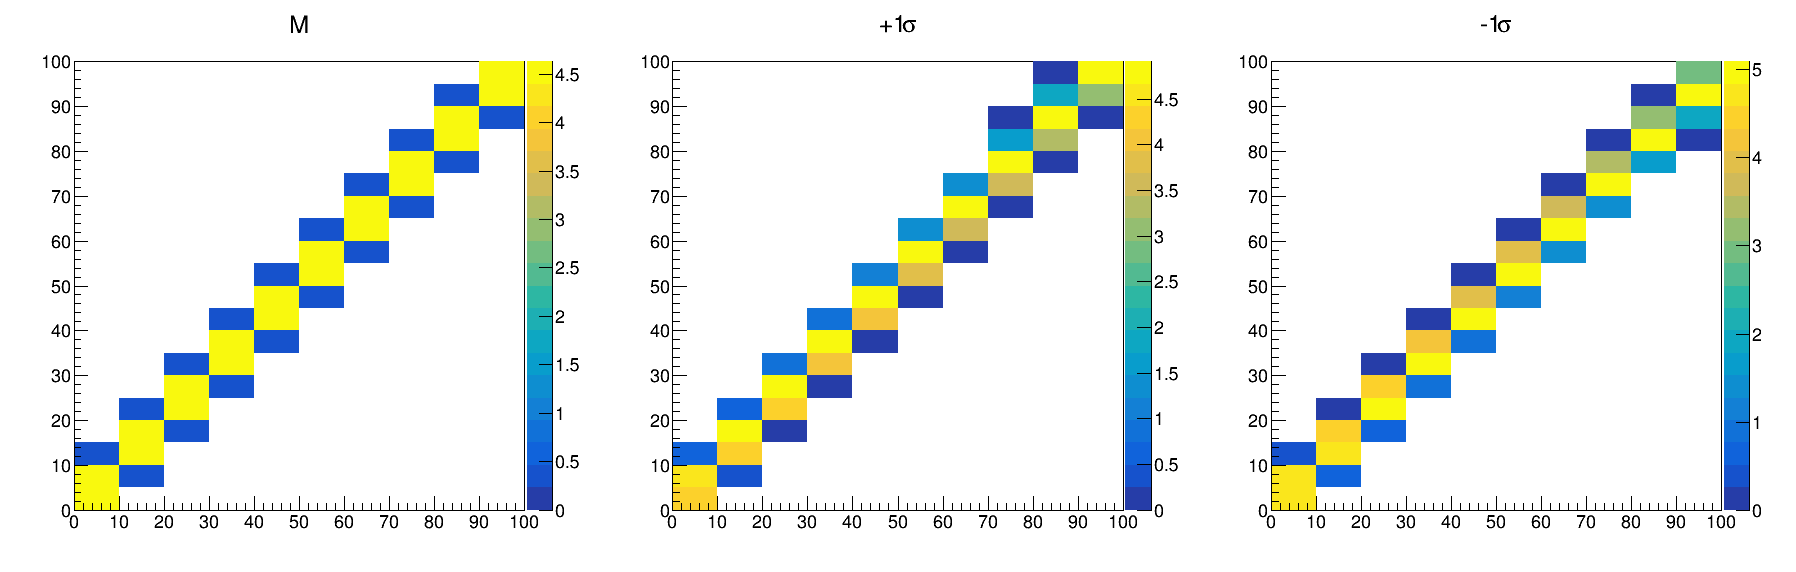

In [4]:

c0 = ROOT.TCanvas("c0", "c0", 1800, 600)
c0.Divide(3,1)
c0.cd(1)
M.Draw("colz")
c0.cd(2)
M1.Draw("colz")
c0.cd(3)
M2.Draw("colz")
c0.Draw()

## Draw the response matrix ratio

We draw the ratio of the $\pm 1 \sigma$ variations to the nominal. 

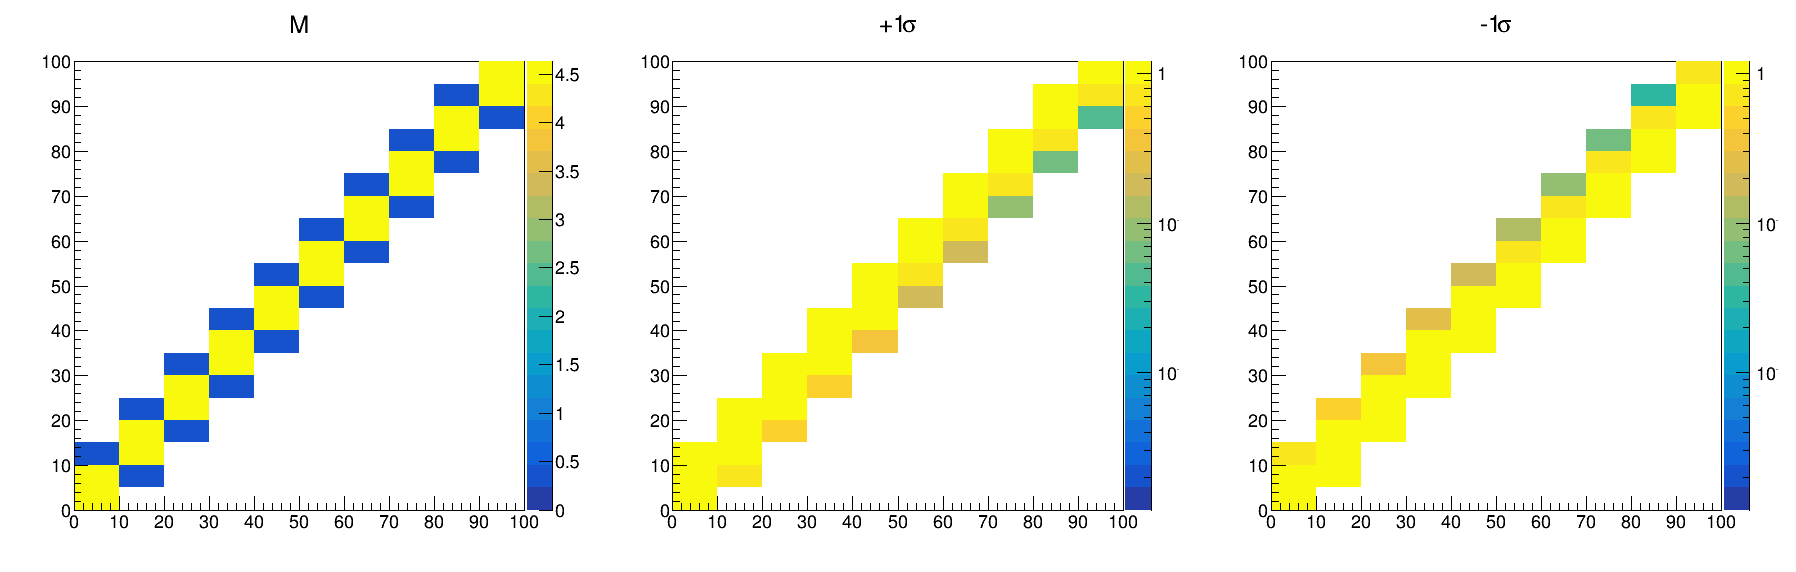

In [5]:

M1ratio = M1.Clone()
M1ratio.Divide(M)
M2ratio = M2.Clone()
M2ratio.Divide(M)
M1ratio.SetMaximum(1.2)
M2ratio.SetMaximum(1.2)

cratio = ROOT.TCanvas("cratio", "cratio", 1800, 600)
cratio.Divide(3,1)
cratio.cd(1)
M.Draw("colz")
cratio.cd(2)
M1ratio.Draw("colz")
ROOT.gPad.SetLogz()
cratio.cd(3)
M2ratio.Draw("colz")
ROOT.gPad.SetLogz()
cratio.Draw()

## Generate a "measurement"

Here, the measured distribution is assumed to be a Gaussian centered in the middle of the distribution, with a width of 30. We smear the true values by the resolution. We also plot the "scale up" and "scale down" variations. 

In [6]:

tvals = np.random.normal(loc=(maxval-minval)/2,scale=30,size=1000000)
xvals = np.random.normal(loc=tvals,scale=res)

print (tvals[:10])
print (xvals[:10])
#yvals = [ x * np.random.normal(loc=1,scale=0.1) for x in xvals ]
h = ROOT.TH1D("h", "h", finebins, minval, maxval)
hup = ROOT.TH1D("hup", "hup", finebins, minval, maxval)
hdn = ROOT.TH1D("hdn", "hdn", finebins, minval, maxval)
hup.SetLineStyle(2)
hdn.SetLineStyle(3)
htrue = ROOT.TH1D("htrue", "htrue", finebins, minval, maxval)
for x in xvals:
    h.Fill(x)
    hup.Fill(x * scaleup)
    hdn.Fill(x * scaledn)
for t in tvals:
    htrue.Fill(t)
    
#h.Scale(1.0/h.Integral())

[ 3.91678648 34.05790002 65.1211677  89.99435548 21.52010165 34.96616342
 49.54547588 26.52203304 76.39843274 65.87240444]
[ 1.97589162 34.03285935 63.95660931 90.9351072  20.42880915 34.44163293
 49.4368991  23.34971917 76.567723   65.88800933]


## Plot the reconstructed and truth

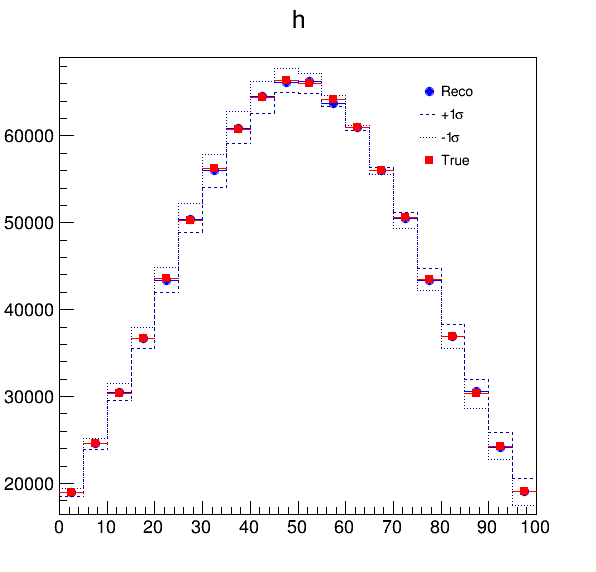

In [7]:
creco = ROOT.TCanvas("creco", "creco", 600, 600)
h.Draw('e')
hup.Draw("hist same")
hdn.Draw("hist same")
htrue.SetLineColor(2)
htrue.Draw("e same")
creco.Draw()
h.SetMarkerStyle(20)
htrue.SetMarkerStyle(21)
h.SetMarkerColor(ROOT.kBlue)
htrue.SetMarkerColor(ROOT.kRed)
h.SetLineColor(ROOT.kBlue)
htrue.SetLineColor(ROOT.kRed)

leg1 = ROOT.TLegend(0.7,0.7,0.86, 0.86)
leg1.SetBorderSize(0)
leg1.SetFillColor(0)
leg1.AddEntry( h, 'Reco', 'p')
leg1.AddEntry( hup, '+1#sigma', 'l')
leg1.AddEntry( hdn, '-1#sigma', 'l')
leg1.AddEntry( htrue, 'True', 'p')
leg1.Draw()

## Unfold

1. Create the `TUnfoldDensity` object. 
1. Add the systematic uncertainty variations via `AddSysError`. 
1. Perform the regularization by scanning the L curve. 
1. Get the output. **Note! This does not account for systematic uncertainties automatically. They must be added by hand.**
1. Draw unfolded versus true distributions (in the same coarse binning scheme). 

Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: 20 input bins and 12 output bins (includes 2 underflow/overflow bins)
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=3 axisSteering=*[UOB]
Info in <TUnfoldDensity::ScanLcurve>: logtau=-Infinity X=3.152255 Y=6.242024
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.543591 X=3.179231 Y=6.161947
Info in <TUnfoldDensity::ScanLcurve>: logtau=-2.043591 X=3.152953 Y=6.227186
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.793591 X=3.157298 Y=6.204098
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.668591 X=3.164408 Y=6.185503
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.606091 X=3.170550 Y=6.174330
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.918591 X=3.154193 Y=6.217799
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.731091 X=3.160164 Y=6.195428
Info in <TUnfoldDensity::ScanLcurve>: logtau=-1.574841 X=3.174528 Y=6.168286
Info in <TUnfoldDensity::ScanLcurve>: logtau=

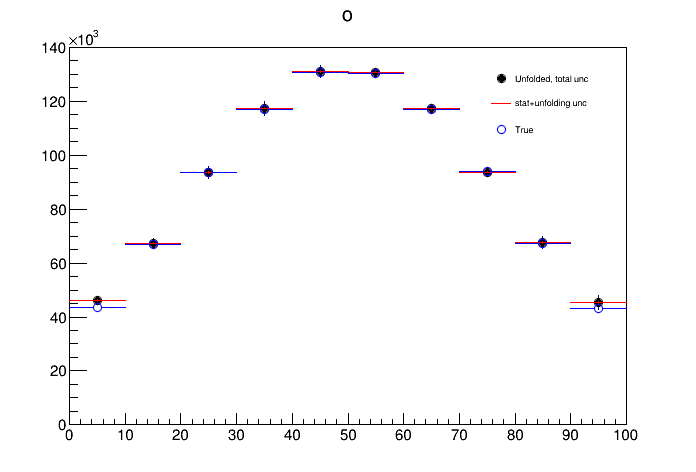

In [8]:
orientation = ROOT.TUnfold.kHistMapOutputHoriz
regMode = ROOT.TUnfold.kRegModeCurvature
con = ROOT.TUnfold.kEConstraintArea #ROOT.TUnfold.kEConstraintArea
mode =  ROOT.TUnfoldDensity.kDensityModeBinWidth
axisSteering =  "*[b]"

u = ROOT.TUnfoldDensity(M,orientation,regMode,con)
u.SetInput( h )
u.AddSysError(M1, "Up", orientation, ROOT.TUnfoldDensity.kSysErrModeShift)
u.AddSysError(M2, "Dn", orientation, ROOT.TUnfoldDensity.kSysErrModeShift)
#ROOT.TUnfoldDensity.kSysErrModeRelative)# ROOT.TUnfoldDensity.kSysErrModeShift)

# Regularize
nScan=50
tauMin=0.0
tauMax=0.0
iBest=0

logTauX = ROOT.MakeNullPointer(ROOT.TSpline)
logTauY = ROOT.MakeNullPointer(ROOT.TSpline)
lCurve = ROOT.MakeNullPointer(ROOT.TGraph)
u.ScanLcurve(nScan,tauMin,tauMax,lCurve,logTauX,logTauY)

# Get output... DOES NOT CONTAIN SYSTEMATICS. 
o = u.GetOutput("o")

# Get systematic shifts of output
o_up = u.GetDeltaSysSource("Up", "o_upshift", "+1#sigma")
o_dn = u.GetDeltaSysSource("Dn", "o_dnshift", "-1#sigma")
o_up.SetLineStyle(2)
o_dn.SetLineStyle(2)

# Get various covariances
cov = u.GetEmatrixTotal("cov", "Covariance Matrix")
cov_uncorr = u.GetEmatrixSysUncorr("cov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties")
cov_uncorr_data = u.GetEmatrixInput("cov_uncorr_data", "Covariance Matrix from Stat Uncertainties of Input Data")

# Now prepare various distributions. 
o_unfunc = o.Clone("o_unc")        # Unfolding and stat unc
o_sys = o.Clone("o_sys")        # Syst uncertainty
o_unctot = o.Clone("o_unctot")  # Total uncertainty
o_sys.SetLineStyle(2)

# Create total uncertainty and sys uncertainty plots. 
# Also fix the uncertainties on the output
for i in range( 0, o_up.GetNbinsX() + 1):
    unc_tot = ROOT.TMath.Sqrt( cov.GetBinContent(i,i) )
    o_unctot.SetBinContent(i, unc_tot )    
    o.SetBinError(i, unc_tot )
    
    yup = abs( o_up.GetBinContent(i))
    ydn = abs( o_dn.GetBinContent(i))
    dy = ROOT.TMath.Sqrt( (yup**2 + ydn**2) )
    o_sys.SetBinContent(i, dy )


htrue2 = htrue.Clone("h2")
htrue2.Rebin(finebins//coarsebins)
o.SetMarkerStyle(20)
o.SetMarkerColor(1)
o_unfunc.SetMarkerStyle(0)
o_unfunc.SetLineColor(2)
htrue2.SetMarkerStyle(21)
htrue2.SetMarkerColor(4)
htrue2.SetMarkerStyle(4)
htrue2.SetLineColor(4)

c = ROOT.TCanvas("c","c")
o.SetMinimum(0.0)
o.Draw()
o_unfunc.Draw("e same")
htrue2.Draw("e same")
leg2 = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
leg2.SetBorderSize(0)
leg2.SetFillColor(0)
leg2.AddEntry( o, "Unfolded, total unc",'p')
leg2.AddEntry( o_unfunc, "stat+unfolding unc",'l')
leg2.AddEntry( htrue2, "True",'p')
leg2.Draw()
c.Draw()



## Draw the LCurve. 

Name: Graph Title: L curve


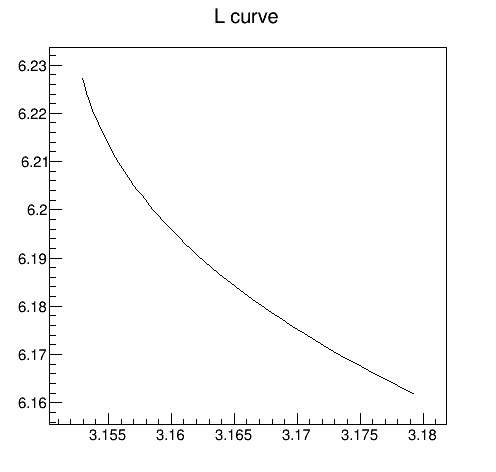

In [9]:
print (lCurve)
if lCurve:
    cl = ROOT.TCanvas("cl", "cl", 500, 500)
    lCurve.Draw("alp")
    cl.Draw()

## Plot closure

The closure plot is the true distribution divided by the unfolded distribution. Aside from the outermost bins, the closure is consistent with unity. 

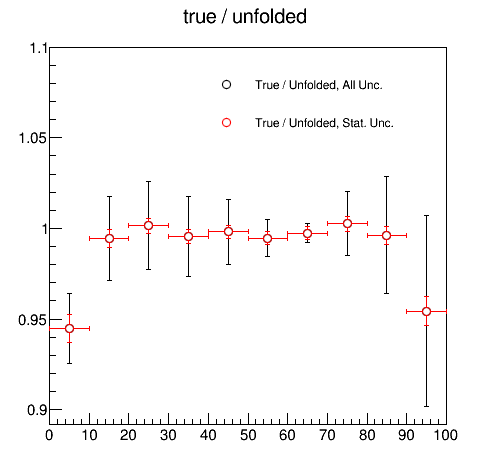

In [10]:
c2 = ROOT.TCanvas("c2", "c2", 500, 500)
closure = htrue2.Clone("closure")
closure2 = htrue2.Clone("closure2")
closure.SetMarkerColor(1)
closure.SetLineColor(1)
closure2.SetMarkerColor(2)
closure2.SetLineColor(2)
closure.SetTitle("true / unfolded")
closure.Divide(o)
closure2.Divide(o_unfunc)
closure.Draw('e1')
closure2.Draw('e1 same')
closure.SetMaximum(1.1)

legclosure = ROOT.TLegend(0.4, 0.7, 0.86, 0.86)
legclosure.SetBorderSize(0)
legclosure.SetFillColor(0)
legclosure.AddEntry( closure, "True / Unfolded, All Unc.", 'p')
legclosure.AddEntry( closure2, "True / Unfolded, Stat. Unc.", 'p')
legclosure.Draw()
c2.Draw()

## Plot the total covariance matrix

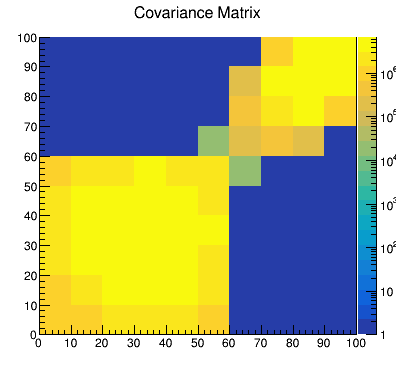

In [11]:

ccov = ROOT.TCanvas("ccov", "Covariance Matrix", 400, 400)
cov.Draw('colz')
ccov.SetLogz()
ccov.Draw()


## Plot the covariance matrix from uncorrelated (stat.) uncertainties

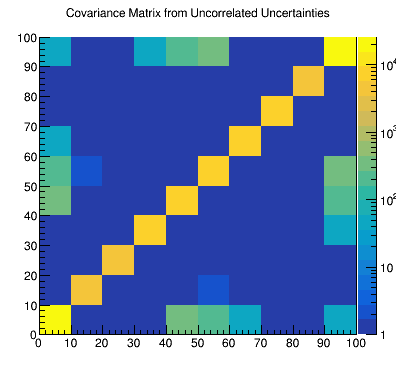

In [12]:

ccov_uncorr = ROOT.TCanvas("ccov_uncorr", "Covariance Matrix from Uncorrelated Uncertainties", 400, 400)
cov_uncorr.Draw('colz')
ccov_uncorr.SetLogz()
ccov_uncorr.Draw()



## Plot covariance matrix of the statistical uncertainties from the input data

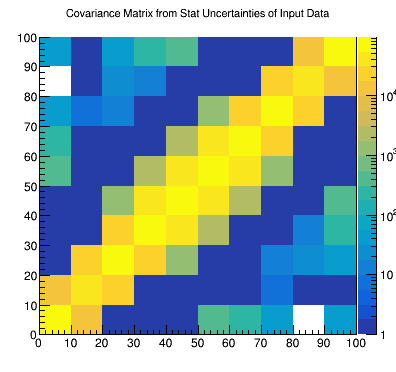

In [13]:

ccov_uncorr_data = ROOT.TCanvas("ccov_uncorr_data", "Covariance Matrix from Uncorrelated Uncertainties", 400, 400)
cov_uncorr_data.Draw('colz')
ccov_uncorr_data.SetLogz()
ccov_uncorr_data.Draw()



## Plot absolute uncertainties



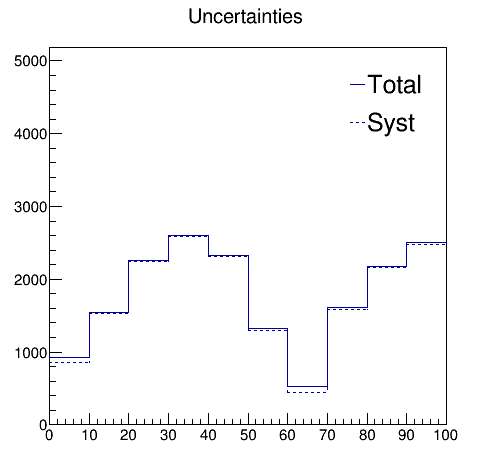

In [14]:

#
unc_stack = ROOT.THStack("unc_stack", "Uncertainties")
unc_stack.Add( o_unctot, "hist" )
unc_stack.Add( o_sys, "hist" )
#o_up.Divide(o)
#o_dn.Divide(o)



c_sys = ROOT.TCanvas("c_sys", "c_sys", 500, 500)
unc_stack.Draw("nostack")
unc_stack.SetMaximum( 1.0 * unc_stack.GetMaximum() )
#o_unc.SetMinimum(-0.2)
#o_unc.SetMaximum(+0.2)
legsys = ROOT.TLegend(0.7, 0.7, 0.86, 0.86)
legsys.SetFillColor(0)
legsys.SetBorderSize(0)
legsys.AddEntry( o_unctot, 'Total', 'l')
legsys.AddEntry( o_sys, 'Syst', 'l')
legsys.Draw()
c_sys.Draw()